# **Segmentação de clientes**

Nessa extensão do projeto do Modelo de Financiamento de Veículos vamos realizar uma segmentação de clientes no data set com os resultados da modelagem.

# Aplicando o modelo

In [1]:
import pandas as pd
import duckdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

Importando novamente o DF original para trabalharmos com ele

In [2]:
# Caminho do arquivo (ajustar conforme necessário)
file_path = '/content/Dataset 1.xlsx'
# Verifique se o arquivo existe antes de carregá-lo
import os
if os.path.exists(file_path):
   excel_data = pd.ExcelFile(file_path)
   print(excel_data.sheet_names)
   df = excel_data.parse('financiamento_veiculos_analytic')
   print(df.head())
else:
   print(f"Arquivo {file_path} não encontrado.")

['financiamento_veiculos_analytic']
   ID_Cliente  Idade     Genero    Regiao Faixa_de_Renda  Valor_Financiado  \
0           1     56   Feminino  Regiao C    Baixa Renda             96231   
1           2     69  Masculino  Regiao A    Media Renda             17314   
2           3     46  Masculino  Regiao A     Alta Renda             29623   
3           4     32   Feminino  Regiao A    Media Renda             77675   
4           5     60  Masculino  Regiao D    Media Renda             75082   

   Prazo_Financiamento (Meses)  Taxa_de_Juros_ao_ano (%)  Valor_Parcela  \
0                           60                     0.352    3145.433332   
1                           48                     0.200     511.964756   
2                           12                     0.200    2721.074668   
3                           48                     0.210    2331.282164   
4                           36                     0.320    3109.184027   

   Modelo_Ano_Veiculo  Valor_Veiculo Status_

Transformando as variavéis com Label e One Hot Enconding

In [3]:
# 1. Label Encoding com pesos reais

df['Faixa_de_Renda'] = df['Faixa_de_Renda'].map({'Baixa Renda': 1, 'Media Renda': 2, 'Alta Renda': 3})
df['Status_Pagamento'] = df['Status_Pagamento'].map({'Em dia': 0, 'Inadimplente': 1})

# 2. One-Hot Encoding nas outras variáveis categóricas

df = pd.get_dummies(df, columns=['Genero', 'Regiao'], drop_first=True)

# Exibir o resultado
display(df)

,ID_Cliente,Idade,Faixa_de_Renda,Valor_Financiado,Prazo_Financiamento (Meses),Taxa_de_Juros_ao_ano (%),Valor_Parcela,Modelo_Ano_Veiculo,Valor_Veiculo,Status_Pagamento,Renda_Media_Regional,Taxa_Inadimplencia_Regional,Genero_Masculino,Regiao_Regiao B,Regiao_Regiao C,Regiao_Regiao D
0,1,56,1,96231,60,0.352,3145.433332,2017,160385.000000,0.0,2500,0.040000,False,False,True,False
1,2,69,2,17314,48,0.200,511.964756,2020,24047.222222,0.0,5000,0.016667,True,False,False,False
2,3,46,3,29623,12,0.200,2721.074668,2012,58084.313725,0.0,5000,0.016667,True,False,False,False
3,4,32,2,77675,48,0.210,2331.282164,2020,121367.187500,0.0,5000,0.016667,False,False,False,False
4,5,60,2,75082,36,0.320,3109.184027,2022,123085.245902,0.0,1500,0.060000,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,65,3,34596,36,0.120,1138.972183,2019,78627.272727,1.0,3500,0.026667,True,True,False,False
496,497,42,2,43174,36,0.340,1823.989879,2016,65415.151515,0.0,5000,0.016667,False,False,False,False
497,498,57,3,74106,60,0.340,2380.620119,2013,139822.641509,0.0,2500,0.040000,False,False,True,False
498,499,62,2,79967,24,0.290,4297.560110,2018,111065.277778,0.0,2500,0.040000,True,False,True,False


Tratando valores Nulos pela mediana

In [4]:
# Substituir valores nulos pela mediana de cada coluna no DataFrame df
df = df.apply(lambda col: col.fillna(col.median()), axis=0)

# Exibir o DataFrame atualizado
print(df)


     ID_Cliente  Idade  Faixa_de_Renda  Valor_Financiado  \
0             1     56               1             96231   
1             2     69               2             17314   
2             3     46               3             29623   
3             4     32               2             77675   
4             5     60               2             75082   
..          ...    ...             ...               ...   
495         496     65               3             34596   
496         497     42               2             43174   
497         498     57               3             74106   
498         499     62               2             79967   
499         500     18               3             69182   

     Prazo_Financiamento (Meses)  Taxa_de_Juros_ao_ano (%)  Valor_Parcela  \
0                             60                     0.352    3145.433332   
1                             48                     0.200     511.964756   
2                             12                

In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


In [6]:
from catboost import CatBoostClassifier

# Retreinando o modelo

Aplicar o K-Means no data set desbalanceado para criar grupos na classe minoritária de forma que os clusters sejam mantidas as caracteristicas e padrões do Data set original.

Após o balanceamento, vamos aplicar o ensemble dos modelos para que ele possa classificar as classes em: "Em dia" ou "Inadiplente"

              precision    recall  f1-score   support

      Em dia       0.99      1.00      0.99        92
Inadimplente       1.00      0.88      0.93         8

    accuracy                           0.99       100
   macro avg       0.99      0.94      0.96       100
weighted avg       0.99      0.99      0.99       100



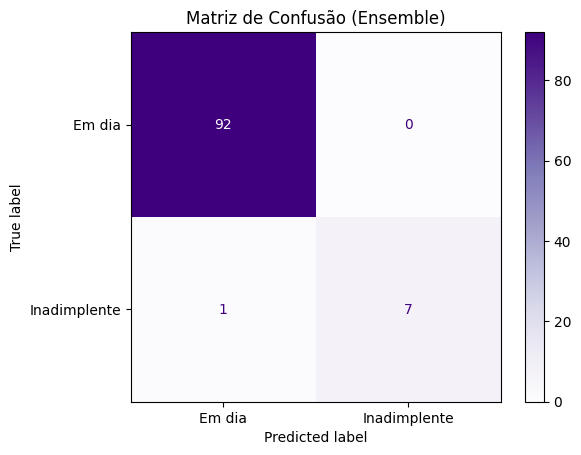

In [7]:
# Separar as variáveis preditoras e alvo
X = df.drop('Status_Pagamento', axis=1)
y = df['Status_Pagamento']


# Aplicar K-Means para criar grupos artificiais na classe minoritária
minority_class = X[y == 1]  # Classe minoritária
kmeans = KMeans(n_clusters=5, random_state=50)  # Criar 5 clusters
clusters = kmeans.fit_predict(minority_class)  # Ajustar o K-Means e obter os clusters


# Adicionar os clusters como nova feature
X['Minoritaria_Cluster'] = 0  # Inicializar com 0
X.loc[y == 1, 'Minoritaria_Cluster'] = clusters  # Adicionar os clusters na classe minoritária


# Escalar as variáveis numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
   X_scaled, y, test_size=0.2, random_state=50, stratify=y
)


# Modelo 1: CatBoost
catboost_model = CatBoostClassifier(
   iterations=200,
   learning_rate=0.1,
   depth=6,
   eval_metric='F1',
   random_seed=50,
   verbose=0  # Silenciar logs do treinamento
)
catboost_model.fit(X_train, y_train)


# Modelo 2: Random Forest
rf_model = RandomForestClassifier(
   n_estimators=200,
   max_depth=6,
   random_state=50
)
rf_model.fit(X_train, y_train)


# Modelo 3: SVM
svm_model = SVC(
   C=10,  # Parâmetro de regularização
   probability=True,  # Habilitar probabilidades (necessário para o ensemble)
   kernel='rbf',  # Kernel radial base function
   class_weight='balanced',  # Balancear as classes automaticamente
   random_state=50
)
svm_model.fit(X_train, y_train)


# Combinar os modelos com VotingClassifier
ensemble_model = VotingClassifier(
   estimators=[
       ('catboost', catboost_model),
       ('random_forest', rf_model),
       ('SVM', svm_model)
   ],
   voting='soft'  # 'soft' usa probabilidades; 'hard' usa previsões diretas
)
# Treinar o ensemble no conjunto de treino
ensemble_model.fit(X_train, y_train)


# Fazer previsões no conjunto de teste
y_pred = ensemble_model.predict(X_test)

# Avaliar o desempenho
# Relatório de métricas
print(classification_report(y_test, y_pred, target_names=['Em dia', 'Inadimplente']))
# Matriz de Confusão
cm_display = ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred, display_labels=['Em dia', 'Inadimplente'], cmap=plt.cm.Purples
)
cm_display.ax_.set_title('Matriz de Confusão (Ensemble)')
plt.show()

# Colocando o modelo para realizar as previsões e adicionando as previsões ao DF.

In [8]:
# Fazer previsões no conjunto de teste
y_pred = ensemble_model.predict(X_test)

In [9]:
# Reconstruir o DataFrame do conjunto de teste
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Adicionar as previsões ao DataFrame
X_test_df['Previsao_Modelo'] = y_pred

# Adicionar o rótulo real para comparação
X_test_df['Status_Real'] = y_test.values

In [10]:
# Fazer previsões para todo o conjunto de dados
y_pred_full = ensemble_model.predict(X_scaled)

# Adicionar as previsões ao DataFrame original
df['Previsao_Modelo'] = y_pred_full

In [11]:
display(df)

,ID_Cliente,Idade,Faixa_de_Renda,Valor_Financiado,Prazo_Financiamento (Meses),Taxa_de_Juros_ao_ano (%),Valor_Parcela,Modelo_Ano_Veiculo,Valor_Veiculo,Status_Pagamento,Renda_Media_Regional,Taxa_Inadimplencia_Regional,Genero_Masculino,Regiao_Regiao B,Regiao_Regiao C,Regiao_Regiao D,Previsao_Modelo
0,1,56,1,96231,60,0.352,3145.433332,2017,160385.000000,0.0,2500,0.040000,False,False,True,False,0.0
1,2,69,2,17314,48,0.200,511.964756,2020,24047.222222,0.0,5000,0.016667,True,False,False,False,0.0
2,3,46,3,29623,12,0.200,2721.074668,2012,58084.313725,0.0,5000,0.016667,True,False,False,False,0.0
3,4,32,2,77675,48,0.210,2331.282164,2020,121367.187500,0.0,5000,0.016667,False,False,False,False,0.0
4,5,60,2,75082,36,0.320,3109.184027,2022,123085.245902,0.0,1500,0.060000,True,False,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,65,3,34596,36,0.120,1138.972183,2019,78627.272727,1.0,3500,0.026667,True,True,False,False,1.0
496,497,42,2,43174,36,0.340,1823.989879,2016,65415.151515,0.0,5000,0.016667,False,False,False,False,0.0
497,498,57,3,74106,60,0.340,2380.620119,2013,139822.641509,0.0,2500,0.040000,False,False,True,False,0.0
498,499,62,2,79967,24,0.290,4297.560110,2018,111065.277778,0.0,2500,0.040000,True,False,True,False,0.0


# Segmentando perfil de clientes com K-means

**Aplicando o K-Means**

In [12]:
variaveis = ['Idade', 'Faixa_de_Renda', 'Valor_Financiado', 'Taxa_de_Juros_ao_ano (%)', 'Previsao_Modelo', 'Prazo_Financiamento (Meses)', 'Renda_Media_Regional']
dados_inadimplentes = df[variaveis]

In [13]:
scaler = StandardScaler()
dados_padronizados = scaler.fit_transform(dados_inadimplentes)

In [14]:
kmeans = KMeans(n_clusters=5, random_state=50)  # Ajuste o número de clusters conforme necessário
clusters = kmeans.fit_predict(dados_padronizados)

# Adicionar os clusters ao DataFrame
df['Cluster'] = clusters

In [15]:
# Resumo estatístico por cluster
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

# Contar o número de clientes em cada cluster
print(df['Cluster'].value_counts())

         ID_Cliente      Idade  Faixa_de_Renda  Valor_Financiado  \
Cluster                                                            
0        250.439560  31.890110        1.142857      48704.439560   
1        259.815534  53.728155        1.349515      62398.611650   
2        240.720000  47.592000        2.440000      76352.752000   
3        247.878049  47.536585        1.878049      57296.219512   
4        253.185714  41.257143        2.621429      34184.807143   

         Prazo_Financiamento (Meses)  Taxa_de_Juros_ao_ano (%)  Valor_Parcela  \
Cluster                                                                         
0                          42.065934                  0.218462    1966.526360   
1                          30.990291                  0.337981    3625.309283   
2                          45.984000                  0.219200    2721.688742   
3                          33.365854                  0.260244    3147.877090   
4                          30.514286 

In [16]:
df.columns

Index(['ID_Cliente', 'Idade', 'Faixa_de_Renda', 'Valor_Financiado',
       'Prazo_Financiamento (Meses)', 'Taxa_de_Juros_ao_ano (%)',
       'Valor_Parcela', 'Modelo_Ano_Veiculo', 'Valor_Veiculo',
       'Status_Pagamento', 'Renda_Media_Regional',
       'Taxa_Inadimplencia_Regional', 'Genero_Masculino', 'Regiao_Regiao B',
       'Regiao_Regiao C', 'Regiao_Regiao D', 'Previsao_Modelo', 'Cluster'],
      dtype='object')

**Selecionando os clientes inadimplentes (cluster = 3)**

In [17]:
query = "SELECT * FROM df WHERE Previsao_Modelo = 1"
result = duckdb.query(query).to_df()

display(result)

,ID_Cliente,Idade,Faixa_de_Renda,Valor_Financiado,Prazo_Financiamento (Meses),Taxa_de_Juros_ao_ano (%),Valor_Parcela,Modelo_Ano_Veiculo,Valor_Veiculo,Status_Pagamento,Renda_Media_Regional,Taxa_Inadimplencia_Regional,Genero_Masculino,Regiao_Regiao B,Regiao_Regiao C,Regiao_Regiao D,Previsao_Modelo,Cluster
0,7,38,2,43130,48,0.12,1122.831106,2019,102690.476190,1.0,1500,0.060000,False,False,False,True,1.0,3
1,18,39,3,84553,48,0.26,2725.598087,2014,162601.923077,1.0,3500,0.026667,True,True,False,False,1.0,3
2,22,47,1,57638,24,0.43,3412.725241,2022,94488.524590,1.0,2500,0.040000,True,False,True,False,1.0,3
3,36,32,2,85418,24,0.30,4624.520803,2022,115429.729730,1.0,1500,0.060000,False,False,False,True,1.0,3
4,40,69,3,82545,12,0.19,7548.960773,2022,105826.923077,1.0,5000,0.016667,True,False,False,False,1.0,3
5,48,35,2,57517,12,0.26,5420.295534,2011,97486.440678,1.0,5000,0.016667,False,False,False,False,1.0,3
6,57,45,1,92197,24,0.17,4505.601829,2011,156266.101695,1.0,5000,0.016667,True,False,False,False,1.0,3
7,60,61,3,93807,48,0.30,3190.707629,2019,234517.500000,1.0,3500,0.026667,False,True,False,False,1.0,3
8,72,59,3,47567,24,0.29,2556.330008,2017,56627.380952,1.0,2500,0.040000,False,False,True,False,1.0,3
9,77,61,3,31427,24,0.18,1548.784903,2020,32068.367347,1.0,5000,0.016667,True,False,False,False,1.0,3


# **Análises de Segmentação com os resultados das previsões do Modelo**

# Analisar Inadimplência por Faixa de Renda

Identificar se clientes com uma determinada faixa de renda tem maior propensão à inadimplência.

In [18]:
query = """
  SELECT
    Faixa_de_Renda,
    COUNT(*) AS qtd_inadimplentes,
    AVG(Valor_Financiado) AS media_valor_financiado
  FROM df
  WHERE Previsao_Modelo = 1
  GROUP BY Faixa_de_Renda
  ORDER BY qtd_inadimplentes
"""
result = duckdb.query(query).to_df()

display(result)

,Faixa_de_Renda,qtd_inadimplentes,media_valor_financiado
0,2,12,47993.583333
1,3,12,58961.583333
2,1,17,62687.235294


**Análise por Faixa de Renda**

**1. Faixa de Renda: Nível 1**

• Essa faixa de renda apresenta o maior número de inadimplentes e o maior valor médio financiado.

• Clientes nessa faixa podem ter maior acesso ao crédito, mas o alto número de inadimplentes indica que financiamentos elevados podem ultrapassar sua capacidade de pagamento.


**2. Faixa de Renda: Nível 2**

• Essa faixa representa um médio valor médio financiado entre os grupos. Mostrando equilibrio entre valor financiado e capacidade de pagamento, sendo um grupo intermediário em termos de risco.

• A quantidade de inadimplentes é considerável, indicando que, mesmo com valores menores financiados, clientes nessa faixa podem enfrentar maior dificuldade para pagar.



**3. Faixa de Renda: Nível 3**

• Clientes dessa faixa possuem um valor médio financiado maior em comparação ao Nível 1.

• Apesar do maior valor financiado, a quantidade de inadimplentes permanece estável, sugerindo que essa faixa pode ter mais resiliência financeira em relação à inadimplência.



# Análise Impacto da Taxa de Juros

Identificar se há uma correlação entre Taxa de juros mais altas e inadimplência.

In [19]:
query = """
  SELECT
    "Taxa_de_Juros_ao_ano (%)",
    COUNT(*) AS qtd_inadimplentes,
    AVG(Valor_Parcela) AS media_valor_parcela,
    AVG("Prazo_Financiamento (Meses)") AS media_prazo_financiamento
  FROM df
  WHERE Previsao_Modelo = 1
  GROUP BY "Taxa_de_Juros_ao_ano (%)"
  ORDER BY "Taxa_de_Juros_ao_ano (%)" DESC;
"""
result = duckdb.query(query).to_df()

display(result)


,Taxa_de_Juros_ao_ano (%),qtd_inadimplentes,media_valor_parcela,media_prazo_financiamento
0,0.43,2,2260.298409,24.0
1,0.38,3,3390.063186,28.0
2,0.36,4,3293.850204,36.0
3,0.35,1,1611.478920,60.0
4,0.31,2,5624.706138,18.0
5,0.30,5,2751.662254,43.2
6,0.29,1,2556.330008,24.0
7,0.28,1,439.323112,36.0
8,0.26,2,4072.946811,30.0
9,0.25,2,4134.900388,18.0


**Análise da Influência da Taxa de Juros **

**1. Taxas de Juros Altas (≥ 0.35%):**

• Associadas a prazos médios mais curtos (24 a 36 meses) e valores de parcela moderados (2.260 a  3.293).
• Menor número de inadimplentes, sugerindo que esses financiamentos são mais seletivos.

**2. Taxas de Juros Intermediárias (0.20% a 0.34%):**

• Concentram o maior número de inadimplentes (até 5 casos), especialmente na faixa de 0.30%.

• Valores médios de parcela variam significativamente ( 2.751 a  5.624), com prazos médios entre 18 e 36 meses.

• Indicam maior risco de inadimplência devido à combinação de prazos curtos e parcelas elevadas.

**3. Taxas de Juros Baixas (< 0.20%):**

• Associadas a financiamentos de longo prazo (60 meses ou mais) e valores médios de parcela mais baixos ( 862 a  947).

• Menor risco de inadimplência, com poucos casos registrados, devido à diluição do valor das parcelas.

# Inadimplência por Prazo de Financiamento

Vamos verificar se prazos mais longos ou mais curtos estão relacionados à inadimplencia.

In [20]:
query = """
  SELECT
      CASE
        WHEN "Prazo_Financiamento (Meses)" <= 12 THEN 'Até 1 ano'
        WHEN "Prazo_Financiamento (Meses)" <= 24 THEN 'Até 2 anos'
        WHEN "Prazo_Financiamento (Meses)" <= 36 THEN 'Até 3 anos'
        WHEN "Prazo_Financiamento (Meses)" <= 60 THEN 'Até 5 anos'
        ELSE 'Mais de 5 anos'
      END AS Prazo,
    COUNT(*) AS qtd_inadimplentes,
    AVG(Valor_Financiado) AS media_valor_financiado
  FROM df
  WHERE Previsao_Modelo = 1
  GROUP BY Prazo
  ORDER BY qtd_inadimplentes  DESC;
"""
result = duckdb.query(query).to_df()

display(result)


,Prazo,qtd_inadimplentes,media_valor_financiado
0,Até 5 anos,17,58601.647059
1,Até 1 ano,11,62777.181818
2,Até 2 anos,10,55479.000000
3,Até 3 anos,3,35859.333333


**Prazo de Financiamento:**

• Financiamentos de longo prazo (até 5 ano) têm a maior quantidade de inadimplentes, com valores financiados médios de R$ 58.601,65.
Contudo, o curto prazo (até 1 ano) Também apresentou uma quantidade consideravel de clientes inadimplentes, indicando que clientes com curto prazo podem estar enfrentando dificuldades para pagar parcelas maiores.

• Prazos intermediários, como até 2/3 anos, apresentam valores financiados menores, enquanto prazos mais longos diluem os riscos, com menor número de inadimplentes.

# Impacto do Valor do Veículo.

Analisar se o valor do veículo tem relação com a inadimplência.

In [22]:
query = """
  SELECT
      CASE
        WHEN Valor_Veiculo <= 10000 THEN 'Até 10K'
        WHEN Valor_Veiculo <= 30000 THEN '10K A 30K'
        WHEN Valor_Veiculo <= 50000 THEN '30K A 50K'
        WHEN Valor_Veiculo <= 70000 THEN '50K A 70K'
        WHEN Valor_Veiculo <= 50000 THEN '70K A 100K'
        ELSE 'Acima de 100K'
        END AS Faixa_Valor_Veiculo,
    COUNT(*) AS qtd_inadimplentes,
    "Prazo_Financiamento (Meses)" AS Prazo_financiamento,
    AVG(Valor_Financiado) AS media_valor_financiado,
    AVG(Valor_Parcela) AS media_valor_parcela
  FROM df
  WHERE Previsao_Modelo = 1
  GROUP BY Faixa_Valor_Veiculo, Prazo_financiamento
  ORDER BY qtd_inadimplentes  DESC;
"""
result = duckdb.query(query).to_df()

display(result)


,Faixa_Valor_Veiculo,qtd_inadimplentes,Prazo_financiamento,media_valor_financiado,media_valor_parcela
0,Acima de 100K,8,48,76144.750000,2381.814329
1,Acima de 100K,5,24,76766.800000,4102.668102
2,Acima de 100K,5,12,74514.600000,7052.478383
3,50K A 70K,5,12,55330.400000,5175.288997
4,50K A 70K,3,48,38041.666667,1199.207592
5,Acima de 100K,3,60,68010.000000,1997.333823
6,10K A 30K,2,60,14128.000000,400.442885
7,Acima de 100K,2,36,48260.000000,1734.090791
8,50K A 70K,2,24,49627.500000,2583.616979
9,10K A 30K,2,24,20137.000000,1171.533058


1. Veículos Acima de 100 mil

• Quantidade de Inadimplentes: 23 (a maior concentração).

• Financiamentos de veículos de alto valor apresentam o maior número de inadimplentes, indicando que valores elevados podem aumentar a dificuldade de pagamento.

• Apesar disso, a média da parcela não é tão alta proporcionalmente, sugerindo que o prazo ou a taxa de juros podem influenciar nesse segmento.


2. Veículos na Faixa de 50 K a 70 K

• Quantidade de Inadimplentes: 11.

• Essa faixa possui o segundo maior número de inadimplentes, com financiamentos de valor intermediário.

• A média do valor das parcelas é semelhante ao segmento de veículos acima de R$ 100 mil, o que pode indicar prazos mais curtos ou taxas de juros mais altas para compensar o menor valor financiado.


3. Veículos na Faixa de 10K 30K

• Quantidade de Inadimplentes: 5.

• Financiamentos de veículos de menor valor têm menos casos de inadimplência.

• A média das parcelas é significativamente menor, indicando que financiamentos mais acessíveis são menos propensos a inadimplência.


4. Veículos na Faixa de  30 K R$

• Quantidade de Inadimplentes: 2

• Esse segmento tem o menor número de inadimplentes, possivelmente devido a um equilíbrio entre valor financiado e capacidade de pagamento.

• A média da parcela está abaixo da faixa de veículos mais caros, mas acima da faixa de menor valor.

# Segmentação por Faixa de Juros e Renda com Taxa de Inadimplência Regional.

In [23]:
query = """
    WITH AUX_BASE_SEGMENTOS AS (
      SELECT
        CASE
            WHEN "Taxa_de_Juros_ao_ano (%)" <= 0.20 THEN 'Baixo'
            WHEN "Taxa_de_Juros_ao_ano (%)" <= 0.40 THEN 'Medio'
            ELSE 'Alto'
        END AS Segmento_Taxa_Juros,
        CASE
            WHEN Faixa_de_Renda = 1 THEN 'Baixa Renda'
            WHEN Faixa_de_Renda = 2 THEN 'Media Renda'
            ELSE 'Alta Renda'
        END AS Segmento_Renda,
        COUNT(*) AS QTD_inadimplentes,
        AVG(Valor_Veiculo) AS media_valor_veiculo,
        Taxa_Inadimplencia_Regional
      FROM df
      WHERE Previsao_Modelo = 1
      GROUP BY Segmento_Taxa_Juros, Segmento_Renda, Taxa_Inadimplencia_Regional
    )

    SELECT
      Segmento_Taxa_Juros,
      Segmento_Renda,
      QTD_inadimplentes,
      media_valor_veiculo,
      Taxa_Inadimplencia_Regional
    FROM AUX_BASE_SEGMENTOS
    ORDER BY QTD_inadimplentes DESC;
"""
result = duckdb.query(query).to_df()

display(result)

,Segmento_Taxa_Juros,Segmento_Renda,QTD_inadimplentes,media_valor_veiculo,Taxa_Inadimplencia_Regional
0,Baixo,Alta Renda,4,54016.480315,0.026667
1,Medio,Media Renda,3,82217.432719,0.060000
2,Baixo,Alta Renda,3,94905.533966,0.016667
3,Medio,Media Renda,3,72429.169737,0.016667
4,Medio,Media Renda,3,39944.574161,0.040000
5,Medio,Baixa Renda,3,101399.379509,0.026667
6,Medio,Baixa Renda,3,90922.857143,0.060000
7,Medio,Baixa Renda,3,77913.654953,0.016667
8,Medio,Baixa Renda,3,79238.399381,0.040000
9,Medio,Alta Renda,2,198559.711538,0.026667


**Influência da Taxa de Juros e Renda:**

• Taxas de juros baixas (0.20% a 0.40%) são o maior fator de risco, idependentemente do segmento de renda.

• Regiões com maior taxa de inadimplência regional apresentam financiamentos de valores menores, reforçando a influência de condições socioeconômicas locais.


• Menor propensão à inadiplência para clientes de alta renda, mas taxas médias aumentam o risco, especialmente em financiamentos de maior valor.


# Segmentação por ano do veículo e rank de inadimplentes.

In [24]:
query = """
    WITH AUX_BASE AS (
      SELECT
        Modelo_Ano_Veiculo AS ano_veiculo,
        COUNT(*) AS QTD_inadimplentes,
        AVG("Taxa_de_Juros_ao_ano (%)") AS media_taxa_juros,
        AVG(Valor_Veiculo) AS media_valor_veiculo
      FROM df
      WHERE Previsao_Modelo = 1
      GROUP BY Modelo_Ano_Veiculo
    )
      SELECT
    ano_veiculo,
    QTD_inadimplentes,
    media_taxa_juros,
    media_valor_veiculo,
    RANK() OVER (ORDER BY QTD_inadimplentes DESC) AS rank_inadimplentes
  FROM AUX_BASE
  ORDER BY QTD_inadimplentes DESC;
"""
result = duckdb.query(query).to_df()

display(result)


,ano_veiculo,QTD_inadimplentes,media_taxa_juros,media_valor_veiculo,rank_inadimplentes
0,2011,6,0.266667,127721.610003,1
1,2020,4,0.197500,87730.144700,2
2,2022,4,0.292500,95063.822439,2
3,2017,4,0.345000,45221.583719,2
4,2021,4,0.280000,49268.185531,2
5,2015,4,0.240000,74480.902299,2
6,2019,3,0.180000,138611.749639,7
7,2013,3,0.336667,64170.454217,7
8,2018,3,0.276667,54618.624987,7
9,2016,2,0.185000,136161.145833,10


**Análise por Ano do Veículo **

**1. Veículos de 2011 (Antigos):**

• Maior quantidade de inadimplentes (6 casos).

• Associados a veículos de alto valor financiado ( 127.721,61) e taxa intermediária (0.2667%)


**2. Veículos Recentes (2020-2022):**

• Menor quantidade de inadimplentes (4 por ano).

• Valores financiados variam amplamente ( 49.268 a  95.063), com taxas de juros entre 0.1975% e 0.2925%


**3. Veículos de 2017 e 2013:**

• Taxas de juros mais altas (acima de 0.33%) e valores intermediários financiados ( 45.221 a  64.170)



# Mapeamento do perfil do cliente inadimplente

**Disclaimer:!!!!!!!!:**


Este projeto foi desenvolvido com dados fictícios e simulados, com o objetivo de aprendizado e demonstração de técnicas analíticas e de Machine Learning.
 Os resultados apresentados são hipotéticos e não refletem cenários ou perfis reais.

Vale destacar que a análise exploratória não tem como intenção classificar ou rotular classes sociais, mas sim explorar padrões nos dados de forma técnica e educativa. Todo o trabalho foi conduzido com respeito e ética, buscando apenas o desenvolvimento de conhecimento.

Com base nos dados e análises, podemos definir o perfil típico do cliente inadimplente considerando fatores como taxa de juros, valor financiado, prazo de financiamento, ano do veículo e faixa de renda.

**1. Perfil Geral**

**Características Financeiras:**

**• Taxa de Juros:**

• Taxas de juros intermediárias (0.20% a 0.40%) estão mais associadas à inadimplência, especialmente em clientes com renda média ou baixa.

**• Valor Financiado:**

• Veículos de alto valor financiado (> 100 mil) apresentam maior inadimplência, apesar de prazos mais curtos.

• Valores intermediários ( 50 mil a  70 mil) também representam risco, combinados com taxas médias.

**• Prazo de Financiamento:**

• Prazos curtos (até 1 ano) concentram a maior quantidade de inadimplentes devido às altas parcelas.

• Prazos longos (acima de 5 anos) diluem o risco, mas são mais comuns em clientes com menor renda.

**Perfil Socioeconômico:**

**• Faixa de Renda:**

• Clientes de baixa renda (< 20 mil) têm maior risco de inadimplência, mesmo com valores financiados mais baixos.

• Clientes de renda média (20 mil a  50 mil) apresentam inadimplência moderada, especialmente com taxas intermediárias e valores intermediários.
• Clientes de alta renda (>  50 mil) têm menor risco, mesmo com valores financiados mais altos.


**2. Perfil por Ano do Veículo**

**Veículos Antigos (2011 e anteriores):**

• Perfil:

• Clientes com veículos antigos apresentam o maior número de inadimplentes.

• Alto valor financiado e taxas intermediárias contribuem para dificuldades de pagamento acumuladas ao longo do tempo.

• Hipótese: A inadimplência nesses casos pode ser resultado de financiamentos antigos que se tornaram insustentáveis, especialmente devido à depreciação do veículo.


**Veículos Recém-Fabricados (2020-2022):**

• Perfil:

• Menor número de inadimplentes, com condições de financiamento mais favoráveis (taxas mais baixas e prazos longos).

• Hipótese: Clientes ainda estão nos primeiros meses de financiamento, com menor pressão financeira inicial.

**Veículos Intermediários (2013-2017):**

• Perfil:

• Taxas mais altas (acima de 0.33%) e valores financiados intermediários aumentam o risco de inadimplência.

• Hipótese: Condições de crédito menos favoráveis nesse período podem ter contribuído para maior inadimplência.

**3. Padrões Regionais**

**• Regiões de Alta Inadimplência:**

• Taxas de inadimplência regional acima de 0.04 estão associadas a clientes de baixa renda, prazos curtos e valores financiados intermediários.

• Regiões de Baixa Inadimplência:

• Regiões economicamente mais estáveis concentram clientes de alta renda e veículos com condições mais acessíveis.


**4. Perfil por Segmento de Veículo**

• Veículos de Baixo Valor (<  30 mil):

• Menor risco de inadimplência, especialmente para prazos longos e taxas baixas.
• Veículos de Valor Intermediário ( 50 mil a  70 mil):

• Concentram inadimplência significativa, especialmente quando combinados com taxas médias e prazos curtos.


• Veículos de Alto Valor (>  100 mil):


• Maior risco de inadimplência, devido a parcelas elevadas, mesmo com condições de financiamento mais favoráveis.


# Conclusão: Perfil do Cliente Inadimplente

**• Faixa de Renda:**
Baixa ou média, com maior sensibilidade a taxas de juros intermediárias.

**• Valor Financiado:**
 Veículos de valor intermediário ( 50 mil a  100 mil) ou alto (> 100 mil).

**• Prazo de Financiamento:** Curto (até 1 ano), com parcelas mais altas

**• Taxa de Juros:**  Intermediária (0.20% a 0.40%)

**• Ano do Veículo:** Mais antigos (2011 e anteriores) ou intermediários (2013-2017).

**• Região:** Áreas com alta taxa de inadimplência regional (> 0.04), onde condições econômicas são mais desfavoráveis.